**Task 1**

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Load the dataset
df = pd.read_csv("bank-loan.csv")  # Use your local path if needed

# Preview
print(df.head())

# Summary statistics
print(df.describe())

#Missing values
print(df.isnull().sum())

   age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608      1.0
1   27   1      10        6      31     17.3   1.362202  4.000798      0.0
2   40   1      15       14      55      5.5   0.856075  2.168925      0.0
3   41   1      15       14     120      2.9   2.658720  0.821280      0.0
4   24   2       2        0      28     17.3   1.787436  3.056564      1.0
              age          ed      employ     address      income     debtinc  \
count  850.000000  850.000000  850.000000  850.000000  850.000000  850.000000   
mean    35.029412    1.710588    8.565882    8.371765   46.675294   10.171647   
std      8.041432    0.927784    6.777884    6.895016   38.543054    6.719441   
min     20.000000    1.000000    0.000000    0.000000   13.000000    0.100000   
25%     29.000000    1.000000    3.000000    3.000000   24.000000    5.100000   
50%     34.000000    1.000000    7.000000    7.000000   35.00000

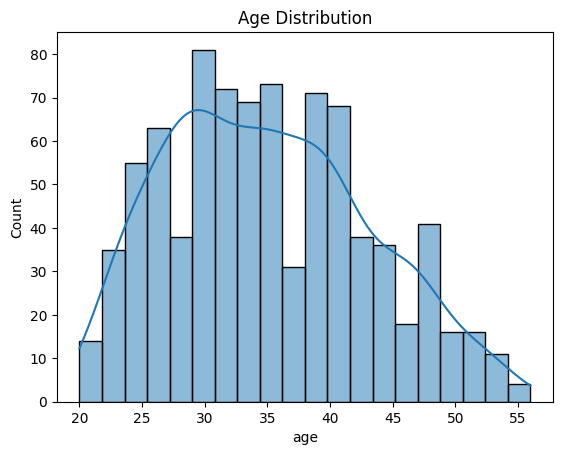

In [38]:
#Visualize distributions
sns.histplot(df['age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

The histogram shows that most borrowers are between 25 and 40 years old, peaking around 30–35. The age distribution is slightly right-skewed, meaning fewer older borrowers are present. This suggests the lending institution’s typical clients are working-age adults likely early or mid-career — relevant when assessing risk, income stability, and default likelihood.

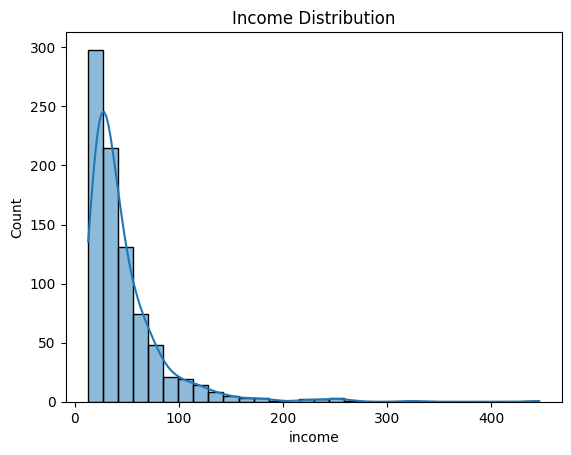

In [39]:
sns.histplot(df['income'], bins=30, kde=True)
plt.title("Income Distribution")
plt.show()

The income distribution is heavily right-skewed — most borrowers earn less than $50–$75K, with a sharp drop as income increases. A few borrowers have much higher incomes (long tail up to $400K+), but they’re rare. This suggests the loan portfolio mainly serves lower to middle-income clients, which could influence default risk if debt burdens are high relative to modest incomes.

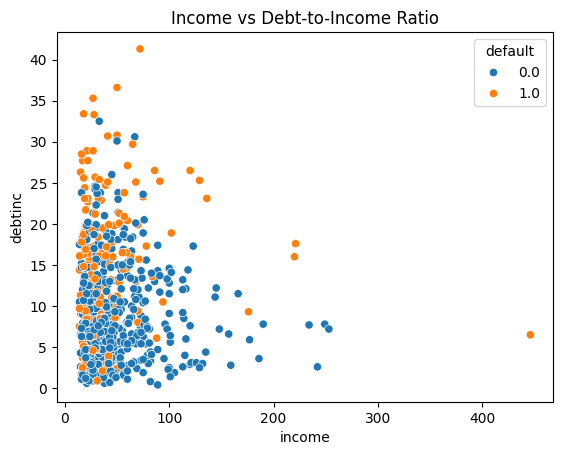

In [40]:
sns.scatterplot(data=df, x="income", y="debtinc", hue="default")
plt.title("Income vs Debt-to-Income Ratio")
plt.show()

The scatterplot shows that lower-income borrowers tend to have higher debt-to-income ratios, and defaults (orange points) are more concentrated in this area. As income rises, debt-to-income ratios generally drop, and defaults become less frequent. This indicates that borrowers with low income and high relative debt are at greater risk of default, highlighting the importance of monitoring these combined factors when assessing loan risk.

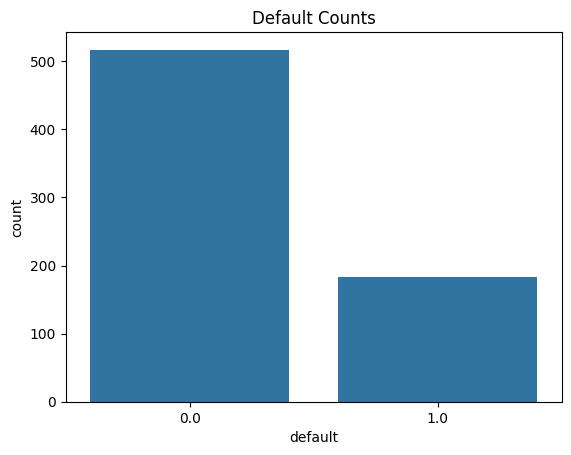

In [41]:
sns.countplot(data=df, x="default")
plt.title("Default Counts")
plt.show()

The bar chart shows that most borrowers did not default (label 0.0), while a smaller but significant portion did default (1.0). This indicates a class imbalance, with non-defaults clearly outnumbering defaults. For model training, this means special care (like balanced sampling or proper metrics) may be needed to avoid the model being biased toward predicting non-defaults.

In [42]:
# --- Clean dataset ---
# Drop rows with missing target
df_clean = df.dropna(subset=['default'])

In [33]:
# Normalize numeric features (scaling is in Task 2)
print(f"Cleaned shape: {df_clean.shape}")


Cleaned shape: (700, 9)


**Task2**

In [14]:
#Feature Engineering & Scaling
from sklearn.preprocessing import StandardScaler


# Copy
df_fe = df_clean.copy()

# Create new features
df_fe['creddebt_income_ratio'] = df_fe['creddebt'] / df_fe['income']
df_fe['othdebt_income_ratio'] = df_fe['othdebt'] / df_fe['income']

print(df_fe[['creddebt_income_ratio', 'othdebt_income_ratio']].head())


--- New Features Created ---
   creddebt_income_ratio  othdebt_income_ratio
0               0.064542              0.028458
1               0.043942              0.129058
2               0.015565              0.039435
3               0.022156              0.006844
4               0.063837              0.109163


In [34]:
#Scale numeric features
features_to_scale = [
    'age', 'ed', 'employ', 'address', 'income', 'debtinc',
    'creddebt', 'othdebt',
    'creddebt_income_ratio', 'othdebt_income_ratio'
]

scaler = StandardScaler()
df_scaled = df_fe.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_fe[features_to_scale])

print(df_scaled.head())


        age        ed    employ   address    income   debtinc  creddebt  \
0  0.768304  1.376911  1.294313  0.545664  3.544603 -0.140798  4.634831   
1 -0.983529 -0.779325  0.242201 -0.334101 -0.396908  1.031818 -0.090444   
2  0.643173 -0.779325  0.993709  0.838919  0.255480 -0.697790 -0.329670   
3  0.768304 -0.779325  0.993709  0.838919  2.022364 -1.078890  0.522369   
4 -1.358922  0.298793 -0.960214 -1.213867 -0.478457  1.031818  0.110547   

    othdebt  default  creddebt_income_ratio  othdebt_income_ratio  
0  0.593692      1.0               0.993866             -0.825825  
1  0.286919      0.0               0.330452              1.227170  
2 -0.270693      0.0              -0.583418             -0.601812  
3 -0.680910      0.0              -0.371157             -1.266913  
4 -0.000501      1.0               0.971162              0.821163  


**Task 3**

In [17]:
#Model Building & Evaluation

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:

# Split
X = df_scaled.drop(['default'], axis=1)
y = df_scaled['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#  Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8142857142857143
Confusion Matrix:
 [[97  5]
 [21 17]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       102
         1.0       0.77      0.45      0.57        38

    accuracy                           0.81       140
   macro avg       0.80      0.70      0.72       140
weighted avg       0.81      0.81      0.80       140



The model’s overall accuracy is about 81%, with strong performance for predicting non-defaults but weaker recall for defaults — showing it misses some actual defaults.

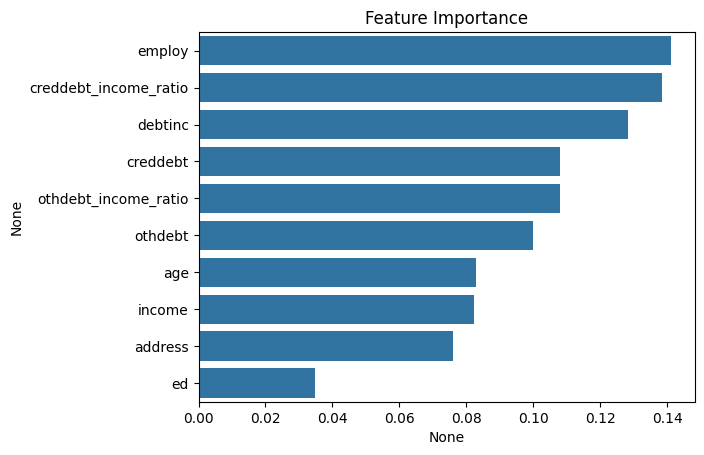

In [36]:
#Feature importance
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance")
plt.show()

Employment length, credit debt ratio, and debt-to-income ratio are the top drivers of default prediction.

**Task 4**

  0%|          | 0/50 [00:00<?, ?it/s]

SHAP shape: (50, 10)
X_test[:50] shape: (50, 10)


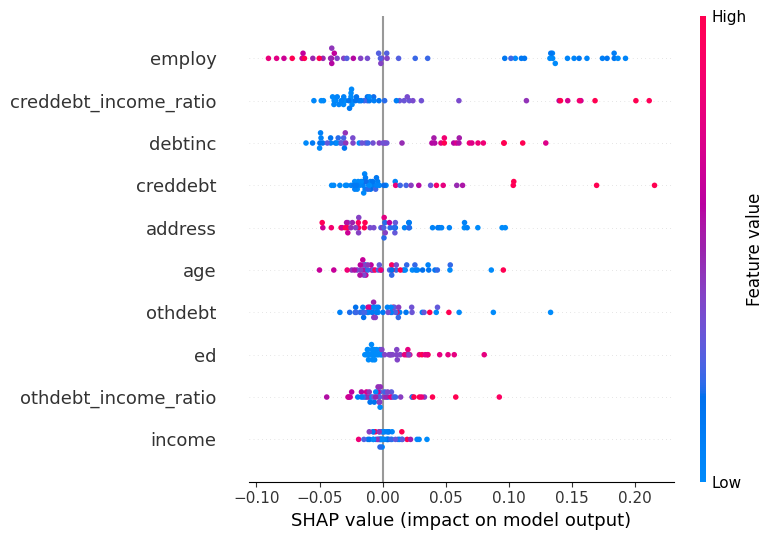

In [44]:
#SHAP Explainability & Fairness
import shap
import numpy as np

# Use predict_proba[:, 1] to explain only class 1 (default)
def predict_default(X):
    return rf.predict_proba(X)[:, 1]

# KernelExplainer with single output
explainer = shap.KernelExplainer(predict_default, X_train[:50])

# Explain on test set
shap_values = explainer.shap_values(X_test[:50])

# Now you get: (samples, features)
print(f"SHAP shape: {np.array(shap_values).shape}")
print(f"X_test[:50] shape: {X_test[:50].shape}")

# Plots
shap.summary_plot(shap_values, features=X_test[:50], feature_names=X_test.columns)

SHAP confirms that employment, credit debt ratio, and debt-to-income ratio push predictions most strongly toward default when their values are higher.

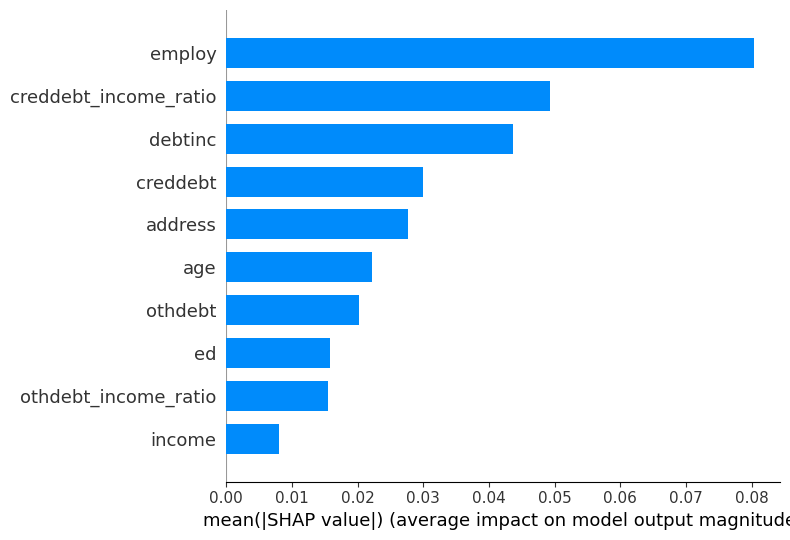

In [43]:
shap.summary_plot(shap_values, features=X_test[:50], feature_names=X_test.columns, plot_type="bar")

The SHAP bar plot confirms employment length and credit debt ratio have the strongest average impact on default predictions.

In [37]:
#Example fairness check: education group
low_ed = X_test[X_test['ed'] <= 2]
high_ed = X_test[X_test['ed'] > 2]

pred_low_ed = rf.predict(low_ed)
pred_high_ed = rf.predict(high_ed)

print("Low ed accuracy:", accuracy_score(y_test[low_ed.index], pred_low_ed))
print("High ed accuracy:", accuracy_score(y_test[high_ed.index], pred_high_ed))

Low ed accuracy: 0.8222222222222222
High ed accuracy: 0.6


Model accuracy is higher for low education borrowers (82%) than for high education borrowers (60%), suggesting a possible fairness gap to monitor.